<a href="https://colab.research.google.com/github/rahuliyer/ai_experiments/blob/main/Leopard_or_Cheetah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leopard, Cheetah, or Jaguar?

This is a notebook to download images from Duck Duck Go and detect whether a picture is that of a leopard, cheetah, or a jaguar.

## Install libraries

In [1]:
#hide
!pip install -Uqq fastai duckduckgo-search

## Prepare the data set

First search for images using the Duck Duck Go library

In [2]:
from duckduckgo_search import DDGS

In [3]:
def search_images(term, max_images=30):
  with DDGS() as ddgs:
        search_results = ddgs.images(keywords=term, max_results=max_images)
        # grap number of max_images urls
        image_urls = [next(search_results).get("image") for _ in range(max_images)]

        return image_urls

Download the images and check if they are ok

In [4]:
from fastdownload import download_url
from fastai.vision.all import *

cheetah_image_urls = search_images("cheetah photos", max_images=1)
cheetah_image_urls[0]


'https://www.rd.com/wp-content/uploads/2019/11/cheetah-8.jpg'

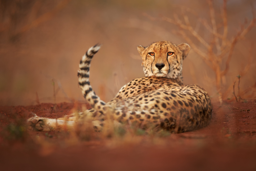

In [5]:
filename = 'cheetah.jpg'
download_url(cheetah_image_urls[0], filename, show_progress=False)
im = Image.open(filename)
im.to_thumb(256,256)

In [6]:
leopard_image_urls = search_images("leopard photos", max_images=1)
leopard_image_urls[0]


'http://www.pixelstalk.net/wp-content/uploads/2016/05/Animal-Leopard-HD-Wallpaper-High-Resolution.jpg'

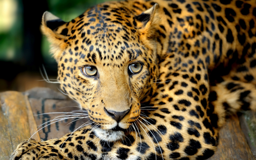

In [7]:
filename = 'leopard.jpg'
download_url(leopard_image_urls[0], filename, show_progress=False)
im = Image.open(filename)
im.to_thumb(256,256)

In [8]:
jaguar_image_urls = search_images("jaguar photos", max_images=1)
jaguar_image_urls[0]

'https://cdn.wallpapersafari.com/96/61/jcFUY5.jpeg'

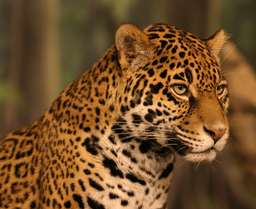

In [9]:
filename = 'jaguar.jpg'
download_url(jaguar_image_urls[0], filename, show_progress=False)
im = Image.open(filename)
im.to_thumb(256,256)

Create a function to download images with sleeps so we don't hammer the server

In [10]:
def download_images_with_interval(urls, dest, batch_size=10, sleep_interval=10):
  index = 0
  while index < len(urls):
    urls_to_download = urls[index:index + batch_size]
    download_images(dest, urls=urls_to_download)
    sleep(sleep_interval)
    index += batch_size


In [11]:
from time import sleep
from pathlib import Path

searches = ['cheetah', 'leopard', 'jaguar']

search_urls = {}

for search in searches:
  search_urls[search] = search_images(f"{search} images", max_images=100)


Download the images into the following tree structure:
```
- data/
    - cheetah/
    - leopard/
    - jaguar/
```



In [12]:
data_dir = Path('data')

if not data_dir.exists():
    max_before_sleep = 10
    sleep_interval = 10
    
    for search in search_urls:
      dest_dir = f"{data_dir}/{search}"
      Path(dest_dir).mkdir(exist_ok=True, parents=True)
    
      download_images_with_interval(search_urls[search], dest_dir)


Clean images that did not download properly

In [13]:
failed = verify_images(get_image_files(data_dir))
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

## Training

In [14]:
def clear_gpu_cache():
    import gc
    gc.collect()
    torch.cuda.empty_cache()

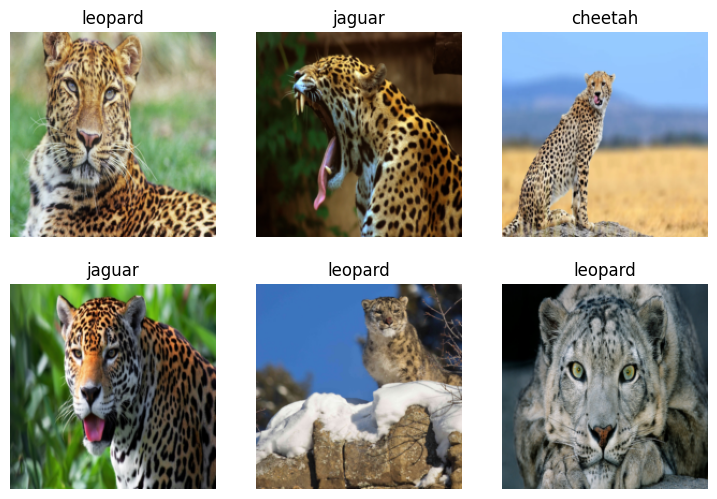

In [15]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(data_dir, bs=32)

dls.show_batch(max_n=6)

In [16]:
callbacks = [
    SaveModelCallback(monitor='valid_loss'),
    EarlyStoppingCallback(monitor='valid_loss', patience=5)
]

learn = vision_learner(dls, resnet18, metrics=error_rate, cbs=callbacks)
learn.fine_tune(30)

Better model found at epoch 0 with valid_loss value: 0.469208300113678.


Better model found at epoch 0 with valid_loss value: 0.4060758054256439.
Better model found at epoch 1 with valid_loss value: 0.3643283545970917.
Better model found at epoch 2 with valid_loss value: 0.3398762047290802.
Better model found at epoch 3 with valid_loss value: 0.3219987154006958.
Better model found at epoch 4 with valid_loss value: 0.3053191900253296.
Better model found at epoch 5 with valid_loss value: 0.28364476561546326.
No improvement since epoch 5: early stopping


In [17]:
learn.predict(PILImage.create('cheetah.jpg'))

('cheetah', tensor(0), tensor([9.9999e-01, 5.8572e-06, 1.6735e-06]))

In [18]:
learn.predict(PILImage.create('leopard.jpg'))

('leopard', tensor(2), tensor([3.0461e-04, 1.6465e-03, 9.9805e-01]))

In [19]:
learn.predict(PILImage.create('jaguar.jpg'))

('jaguar', tensor(1), tensor([2.1621e-05, 9.9925e-01, 7.2584e-04]))

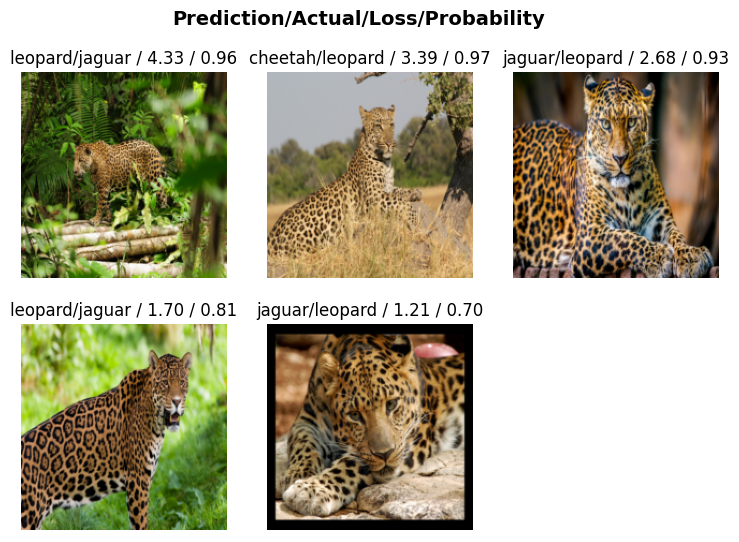

In [20]:
Interpretation.from_learner(learn).plot_top_losses(5)

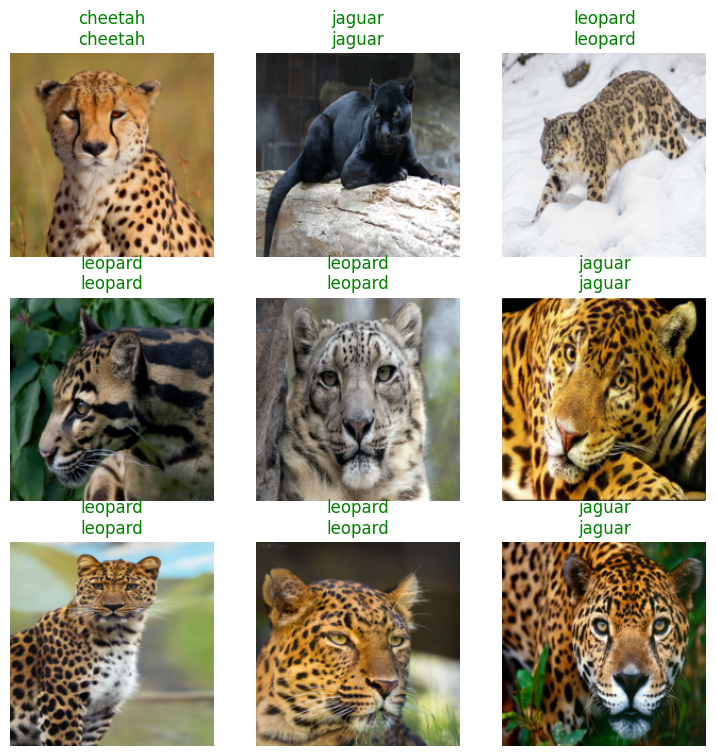

In [21]:
learn.show_results()

Now let's try a bigger model

In [22]:
del learn
clear_gpu_cache()

In [23]:
learn = vision_learner(dls, resnet50, metrics=error_rate, cbs=callbacks)
learn.fine_tune(30)

Better model found at epoch 0 with valid_loss value: 0.26789671182632446.


Better model found at epoch 0 with valid_loss value: 0.2718736529350281.
No improvement since epoch 0: early stopping


In [24]:
learn.predict(PILImage.create('cheetah.jpg'))

('cheetah', tensor(0), tensor([9.9998e-01, 1.6748e-05, 3.9657e-07]))

In [25]:
learn.predict(PILImage.create('leopard.jpg'))

('leopard', tensor(2), tensor([0.0052, 0.1758, 0.8190]))

In [26]:
learn.predict(PILImage.create('jaguar.jpg'))

('jaguar', tensor(1), tensor([0.0041, 0.9226, 0.0732]))

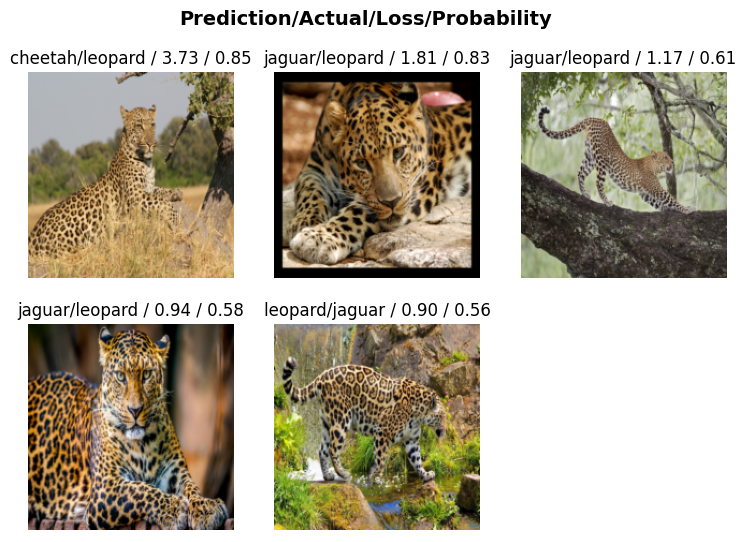

In [27]:
Interpretation.from_learner(learn).plot_top_losses(5)

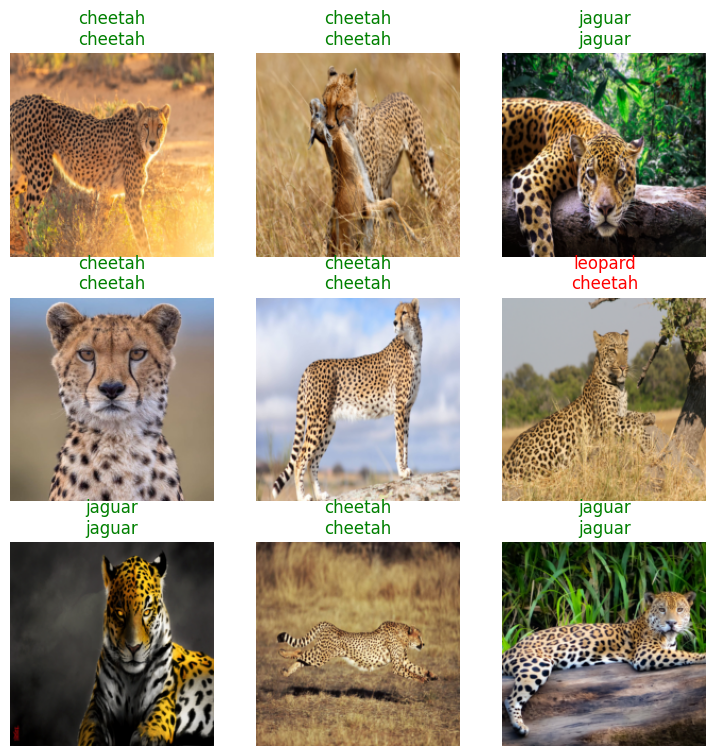

In [28]:
learn.show_results()